GW190425_MinimalNS.ipynb -- reweight GW190425 posterior to minimal NS population

In [1]:
# import packages

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import h5py
import requests as rq
import random
random.seed(2022)

In [2]:
# import sodapop

! git clone https://github.com/landryp/sodapop.git # only need to run this once
import sys
import os
sys.path.insert(0,os.getcwd()+'/sodapop')
import sodapop.priors as prior
import sodapop.populations as pop

Cloning into 'sodapop'...
remote: Enumerating objects: 763, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 763 (delta 55), reused 49 (delta 34), pack-reused 683
Receiving objects: 100% (763/763), 2.76 MiB | 8.13 MiB/s, done.
Resolving deltas: 100% (417/417), done.


In [3]:
# get gw190425 posterior samples

public_dcc_url= 'https://dcc.ligo.org/public/0169/P2000223/007/'
!curl -O {public_dcc_url}"GW190425.tar"
!tar -xvf "$PWD/GW190425.tar" -C "$PWD"

raw_data = h5py.File(os.getcwd()+'/GW190425/GW190425.h5','r')
data = raw_data['C01:IMRPhenomPv2_NRTidal-LS']['posterior_samples']
print(data.dtype.names)
data = pd.DataFrame(np.array(data),columns=['mass_1','mass_2','mass_1_source','mass_2_source','chirp_mass_source','mass_ratio','a_1','a_2','cos_tilt_1','cos_tilt_2','spin_1z','spin_2z','chi_eff','lambda_1','lambda_2','lambda_tilde','luminosity_distance'])
data = data.rename(columns={'mass_1':'m1_detector_frame_Msun','mass_2':'m2_detector_frame_Msun','mass_1_source':'m1','mass_2_source':'m2','mass_ratio':'q','chirp_mass_source':'mchirp','a_1':'spin1','a_2':'spin2','cos_tilt_1':'costilt1','cos_tilt_2':'costilt2','lambda_1':'lambda1','lambda_2':'lambda2','lambda_tilde':'lambdatilde','luminosity_distance':'luminosity_distance_Mpc'})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1179M  100 1179M    0     0  43.6M      0  0:00:27  0:00:27 --:--:-- 45.9M
GW190425/
GW190425/GW190425.h5
GW190425/GW190425_comoving.h5
GW190425/GW190425_AlignedSpinInspiralTidal_LS.fits
GW190425/GW190425_AlignedSpinTidal_HS.fits
GW190425/GW190425_AlignedSpinTidal_LS.fits
GW190425/GW190425_C01:IMRPhenomD_NRTidal-LS.fits
GW190425/GW190425_C01:TaylorF2-HS.fits
GW190425/GW190425_C01:IMRPhenomPv2_NRTidal-HS.fits
GW190425/GW190425_C01:IMRPhenomPv2_NRTidal-LS.fits
GW190425/GW190425_C01:SEOBNRv4T_surrogate_HS.fits
GW190425/GW190425_C01:SEOBNRv4T_surrogate_lowspin_RIFT.fits
GW190425/GW190425_C01:SEOBNRv4T_surrogate_LS.fits
GW190425/GW190425_C01:TaylorF2-LS.fits
GW190425/GW190425_C01:TEOBResumS-HS.fits
GW190425/GW190425_C01:TEOBResumS-LS.fits
GW190425/GW190425_PrecessingSpinIMRTidal_HS.fits
GW190425/GW190425_PrecessingSpinIMRTidal_LS.f

In [4]:
# define transformed observables

H0 = 67.4 # planck 2018 H0 in km/s/Mpc Used to account of change of masses from the red shift. Use this for GW190425. 
c = 2.998e5 # speed of light in km/s

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

In [5]:
# define new population-informed prior and reweight gw190425 posterior samples to it

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det_quad_dL') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('unif_m1m2_unif_chi1_unif_chi2_unif_Lambda1Lambda2') # function of m1, m2, chi1, chi2, Lambda1, Lambda2, population parameters
pop_params = [1.2, 2.3, 0., 0.7, 0., 5000.] # fiducial model

#data = data.truncate(after=1000)

# weight samples based on minimal mass prior
data['massweight']  = data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data['massweight']=[d[0] for d in data['massweight']/data['massweight'].sum() * data['massweight'].size]

In [6]:
# store the unweighted and reweighted samples in a dataframe

data0 = data.copy()
data0['massweight'] = np.ones(len(data0['massweight']))

data['prior'] = 'Minimal'
data0['prior'] = 'LVC'

df = pd.concat([data, data0]).reset_index()

neff = int(data['massweight'].sum()**2/np.sum(data['massweight']**2))

print('Neff {0}'.format(data['prior'][0]),neff)
print('Neff {0}'.format(data0['prior'][0]),len(data0))

Neff Minimal 11636
Neff LVC 46709


In [7]:
# now let's add a more sophisticated spin prior, and reweight the population again

new_prior_mass=pop.get_pop_prior('unif_m1m2_dns_spins_unif_Lambda1Lambda2') # function of m1, m2, chi1, chi2, cost1, cost2, Lambda1, Lambda2, population parameters
pop_params = [1.2, 2.3, 0., 0., 0.05, -2., 0., 0.05, 0., 5000.] # fiducial model

data1 = data0.copy()

# weight samples based on minimal mass prior
data1['massweight']  = data1.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['costilt1'],row['costilt2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data1['massweight']=[d[0] for d in data1['massweight']/data1['massweight'].sum() * data1['massweight'].size]

In [8]:
# let's repeat the procedure with a more sophisticated tidal prior, and reweight the population again

new_prior_mass=pop.get_pop_prior('unif_m1m2_unif_chi1_unif_chi2_common_Lambda1Lambda2') # function of m1, m2, chi1, chi2, Lambda1, Lambda2, population parameters
pop_params = [1.2, 2.3, 0., 0.7, 0., 5000.] # fiducial model

data2 = data0.copy()

# weight samples based on minimal mass prior
data2['massweight']  = data2.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data2['massweight']=[d[0] for d in data2['massweight']/data2['massweight'].sum() * data2['massweight'].size]

In [9]:
# define new population-informed prior and reweight gw190425 posterior samples to it

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det_quad_dL') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2_dns_spins_common_Lambda1Lambda2') # function of m1, m2, chi1, chi2, cost1, cost2, Lambda1, Lambda2, population parameters
pop_params = [1.34, 0.07, 1.80, 0.21, 0.65, 0.9, 2.12, 0., 0., 0.05, -2., 0., 0.05, 0., 5000.] # maximum a posteriori population model from arXiv:1709.07889

data3 = data0.copy()

# weight samples based on galactic mass prior
data3['massweight']  = data3.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['costilt1'],row['costilt2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data3['massweight']=[d[0] for d in data3['massweight']/data3['massweight'].sum() * data3['massweight'].size]

In [10]:
# define new population-informed prior and reweight gw170817 posterior samples to it

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det_quad_dL') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2_unif_chi1_unif_chi2_unif_Lambda1Lambda2') # function of m1, m2, chi1, chi2, cost1, cost2, Lambda1, Lambda2, population parameters
pop_params = [1.34, 0.07, 1.80, 0.21, 0.65, 0.9, 2.12, 0., 0.7, 0., 5000.] # maximum a posteriori population model from arXiv:1709.07889

data4 = data0.copy()

# weight samples based on galactic mass prior
data4['massweight']  = data4.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['spin1'],row['spin2'],row['lambda1'],row['lambda2'],pop_params)  
                            /  old_prior_mass(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data4['massweight']=[d[0] for d in data4['massweight']/data4['massweight'].sum() * data4['massweight'].size]

In [11]:
# store the unweighted and reweighted samples in a dataframe

data1['prior'] = 'Minimal + Spin'
data2['prior'] = 'Minimal + Tidal'
data3['prior'] = 'Galactic'
data4['prior'] = 'Minimal + Mass'

marg_df = pd.concat([data, data0, data1, data2, data3, data4]).reset_index()

neff1 = int(data1['massweight'].sum()**2/np.sum(data1['massweight']**2))
neff2 = int(data2['massweight'].sum()**2/np.sum(data2['massweight']**2))
neff3 = int(data3['massweight'].sum()**2/np.sum(data3['massweight']**2))
neff4 = int(data4['massweight'].sum()**2/np.sum(data4['massweight']**2))

print('Neff {0}'.format(data1['prior'][0]),neff1)
print('Neff {0}'.format(data2['prior'][0]),neff2)
print('Neff {0}'.format(data3['prior'][0]),neff3)
print('Neff {0}'.format(data4['prior'][0]),neff4)

Neff Minimal + Spin 1080
Neff Minimal + Tidal 2282
Neff Galactic 50
Neff Minimal + Mass 11877


In [12]:
# calculate medians and 90% credible intervals

def kde_quantile(data,quant,bounds,wts=None,stp=0.01):

  p_of_data = scipy.stats.gaussian_kde(data,weights=wts)
  data_grid = np.arange(bounds[0],bounds[1],stp)
  num_stp = len(data_grid)

  prob = 0.
  i = 0

  if quant > 0.5:
    
    quant = 1.-quant
    while prob < quant:

      i = i+1
      prob = np.trapz(p_of_data(data_grid[num_stp-i:]),data_grid[num_stp-i:])

    return np.around(data_grid[num_stp-i],-int(np.log10(stp)))

  else:
  
    while prob < quant:

      i = i+1
      prob = np.trapz(p_of_data(data_grid[:i]),data_grid[:i])

    return np.around(data_grid[i-1],-int(np.log10(stp)))

def print_med_90cl(var,data,bounds,wts=None,stp=0.01):

  num_dec = -int(np.log10(stp))
  if num_dec < 0: num_dec = 0

  return print('${0} = {1:.{prec}f}_{{-{2:.{prec}f}}}^{{+{3:.{prec}f}}}$'.format(var,kde_quantile(data,0.5,bounds,wts,stp),np.around(kde_quantile(data,0.5,bounds,wts,stp)-kde_quantile(data,0.05,bounds,wts,stp),num_dec),np.around(kde_quantile(data,0.95,bounds,wts,stp)-kde_quantile(data,0.5,bounds,wts,stp),num_dec), prec=num_dec))

print_med_90cl('m1',marg_df[marg_df['prior']=='Minimal']['m1'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal']['massweight'])
print_med_90cl('m1',marg_df[marg_df['prior']=='Minimal + Mass']['m1'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Mass']['massweight'])
print_med_90cl('m1',marg_df[marg_df['prior']=='Minimal + Spin']['m1'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Spin']['massweight'])
print_med_90cl('m1',marg_df[marg_df['prior']=='Minimal + Tidal']['m1'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Tidal']['massweight'])

print_med_90cl('m2',marg_df[marg_df['prior']=='Minimal']['m2'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal']['massweight'])
print_med_90cl('m2',marg_df[marg_df['prior']=='Minimal + Mass']['m2'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Mass']['massweight'])
print_med_90cl('m2',marg_df[marg_df['prior']=='Minimal + Spin']['m2'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Spin']['massweight'])
print_med_90cl('m2',marg_df[marg_df['prior']=='Minimal + Tidal']['m2'],(0.5,2.5),wts=marg_df[marg_df['prior']=='Minimal + Tidal']['massweight'])

print_med_90cl('q',marg_df[marg_df['prior']=='Minimal']['q'],(0.,1.),wts=marg_df[marg_df['prior']=='Minimal']['massweight'])
print_med_90cl('q',marg_df[marg_df['prior']=='Minimal + Mass']['q'],(0.,1.),wts=marg_df[marg_df['prior']=='Minimal + Mass']['massweight'])
print_med_90cl('q',marg_df[marg_df['prior']=='Minimal + Spin']['q'],(0.,1.),wts=marg_df[marg_df['prior']=='Minimal + Spin']['massweight'])
print_med_90cl('q',marg_df[marg_df['prior']=='Minimal + Tidal']['q'],(0.,1.),wts=marg_df[marg_df['prior']=='Minimal + Tidal']['massweight'])

print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='Minimal']['chi_eff'],(-1.,1.),wts=marg_df[marg_df['prior']=='Minimal']['massweight'])
print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='Minimal + Mass']['chi_eff'],(-1.,1.),wts=marg_df[marg_df['prior']=='Minimal + Mass']['massweight'])
print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='Minimal + Spin']['chi_eff'],(-1.,1.),wts=marg_df[marg_df['prior']=='Minimal + Spin']['massweight'])
print_med_90cl('\\chi_\\rm{eff}',marg_df[marg_df['prior']=='Minimal + Tidal']['chi_eff'],(-1.,1.),wts=marg_df[marg_df['prior']=='Minimal + Tidal']['massweight'])

print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='Minimal']['lambdatilde'],(0.,2000.),wts=marg_df[marg_df['prior']=='Minimal']['massweight'],stp=10.)
print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='Minimal + Mass']['lambdatilde'],(0.,2000.),wts=marg_df[marg_df['prior']=='Minimal + Mass']['massweight'],stp=10.)
print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='Minimal + Spin']['lambdatilde'],(0.,2000.),wts=marg_df[marg_df['prior']=='Minimal + Spin']['massweight'],stp=10.)
print_med_90cl('\\tilde{\\Lambda}',marg_df[marg_df['prior']=='Minimal + Tidal']['lambdatilde'],(0.,2000.),wts=marg_df[marg_df['prior']=='Minimal + Tidal']['massweight'],stp=10.)

$m1 = 1.77_{-0.10}^{+0.16}$
$m1 = 1.81_{-0.14}^{+0.18}$
$m1 = 1.79_{-0.12}^{+0.17}$
$m1 = 1.76_{-0.09}^{+0.15}$
$m2 = 1.57_{-0.14}^{+0.08}$
$m2 = 1.54_{-0.15}^{+0.11}$
$m2 = 1.55_{-0.14}^{+0.10}$
$m2 = 1.58_{-0.13}^{+0.07}$
$q = 0.89_{-0.15}^{+0.08}$
$q = 0.86_{-0.16}^{+0.11}$
$q = 0.87_{-0.15}^{+0.10}$
$q = 0.91_{-0.14}^{+0.06}$
$\chi_\rm{eff} = 0.02_{-0.02}^{+0.00}$
$\chi_\rm{eff} = 0.02_{-0.02}^{+0.01}$
$\chi_\rm{eff} = 0.02_{-0.01}^{+0.01}$
$\chi_\rm{eff} = 0.01_{-0.01}^{+0.01}$
$\tilde{\Lambda} = 390_{-290}^{+970}$
$\tilde{\Lambda} = 370_{-280}^{+960}$
$\tilde{\Lambda} = 450_{-360}^{+990}$
$\tilde{\Lambda} = 250_{-200}^{+550}$


In [13]:
# reflect kde

reflected_df = {'q': [],'lambdatilde': [],'chi_eff': [],'massweight': [],'prior': []}
reflected_df_1d = {'q': [],'lambdatilde': [],'chi_eff': [],'massweight': [],'prior': []}
reflected_idx = 0

for idx in list(marg_df.index.values):

	q = marg_df.at[idx,'q']
	Lt = marg_df.at[idx,'lambdatilde']
	
	if q > 0.9:
		reflected_df['massweight'] += [marg_df.massweight[idx]]
		reflected_df['prior'] += [marg_df.prior[idx]]
		reflected_df['q'] += [1. + np.abs(1.-q)]
		reflected_df['lambdatilde'] += [marg_df.lambdatilde[idx]]
		reflected_df['chi_eff'] += [np.nan]

		reflected_df_1d['massweight'] += [marg_df.massweight[idx]]
		reflected_df_1d['prior'] += [marg_df.prior[idx]+'_1d']
		reflected_df_1d['q'] += [1. + np.abs(1.-q)]
		reflected_df_1d['lambdatilde'] += [np.nan]
		reflected_df_1d['chi_eff'] += [np.nan]

		reflected_idx = reflected_idx + 1
		
	if Lt < 50.:
		reflected_df['massweight'] += [marg_df.massweight[idx]]
		reflected_df['prior'] += [marg_df.prior[idx]]
		reflected_df['q'] += [marg_df.q[idx]]
		reflected_df['lambdatilde'] += [-np.abs(Lt)]
		reflected_df['chi_eff'] += [np.nan]
	
		reflected_df_1d['massweight'] += [marg_df.massweight[idx]]
		reflected_df_1d['prior'] += [marg_df.prior[idx]+'_1d']
		reflected_df_1d['q'] += [np.nan]
		reflected_df_1d['lambdatilde'] += [-np.abs(Lt)]
		reflected_df_1d['chi_eff'] += [np.nan]

		reflected_idx = reflected_idx + 1

reflected_df = pd.DataFrame(reflected_df)
reflected_df_1d = pd.DataFrame(reflected_df_1d)
marg_df_1d = marg_df.copy()
for idx in list(marg_df.index.values): marg_df_1d['prior'][idx] = marg_df_1d['prior'][idx]+'_1d'
marg_df = pd.concat([marg_df,reflected_df,marg_df_1d,reflected_df_1d]).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# specify some global plot settings

sns.set_palette([sns.color_palette("Paired")[1],sns.color_palette("Paired")[3],'k',sns.color_palette("Paired")[8]])
palette = {"Minimal (prior)": 'gray', 'LVC (prior)': sns.color_palette()[1], 'Galactic': sns.color_palette()[2], 'LVC': sns.color_palette()[1], 'Minimal': sns.color_palette()[-1], 'Minimal + Spin': sns.color_palette()[-1], 'Minimal + Tidal': sns.color_palette()[-1], 'Minimal + Mass': sns.color_palette()[-1], 'Galactic_1d': sns.color_palette()[2], 'Minimal_1d': sns.color_palette()[-1], 'Minimal + Spin_1d': sns.color_palette()[-1], 'Minimal + Tidal_1d': sns.color_palette()[-1], 'Minimal + Mass_1d': sns.color_palette()[-1]}

replacements = {'m1': r'$m_1 \,[M_\odot]$', 'm2': r'$m_2 \,[M_\odot]$', 'spin1': r'$\chi_1$', 'spin2': r'$\chi_2$', 'lambda1': r'$\Lambda_1$', 'lambda2': r'$\Lambda_2$', 'mchirp': r'$\mathcal{M} \,[M_\odot]$', 'q': r'$q$', 'chi_eff': r'$\chi_\mathrm{eff}$', 'lambdatilde': r'$\tilde{\Lambda}$', 'costilt1': r'$\cos{\theta_1}$', 'costilt2': r'$\cos{\theta_2}$'}
limits = {'m1': (1.4,2.2), 'm2': (1.2,1.8), 'spin1': (0.,1.), 'spin2': (0.,1.), 'lambda1': (0.,2500.), 'lambda2': (0.,2500.), 'mchirp': (1.1,1.2), 'q': (0.6,1.), 'chi_eff': (-0.01,0.04), 'lambdatilde': (0.,2000.)}

posts = ['Galactic','Minimal']
traces1 = ['Minimal + Spin']
traces2 = ['Minimal + Tidal']
traces3 = ['Minimal + Mass']

diag_posts = ['Galactic_1d','Minimal_1d']
diag_traces1 = ['Minimal + Spin_1d']
diag_traces2 = ['Minimal + Tidal_1d']
diag_traces3 = ['Minimal + Mass_1d']

handles = {}
for key in palette.keys():
  if '(prior)' in key: handles[key] = mlines.Line2D([], [], color=palette[key], ls=':', label=key)
  elif key == 'Minimal + Spin': handles[key] = mlines.Line2D([], [], color=palette['Minimal'], label=key, linestyle='-.', alpha=0.5)
  elif key == 'Minimal + Tidal': handles[key] = mlines.Line2D([], [], color=palette['Minimal'], label=key, linestyle=':', alpha=0.5)
  elif key == 'Minimal + Mass': handles[key] = mlines.Line2D([], [], color=palette['Minimal'], label=key, linestyle='--', alpha=0.5)
  else: handles[key] = mlines.Line2D([], [], color=palette[key], label=key)

In [15]:
def fancy_corner(df,vars,hue_col='prior',wt_col='massweight',posts=posts,post_levels=[0.1,0.5],traces1=traces1,traces2=traces2,trace_levels=[0.1],trace_alpha=0.5,handles=handles,palette=palette,replacements=replacements,limits=limits,height=2.5):

  fig = sns.PairGrid(df, vars=vars, corner=True, diag_sharey=False,height=height)
  
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=diag_traces1, palette=palette, fill=False, alpha=trace_alpha, common_norm=False, weights=df[wt_col], linestyle='-.', linewidth=3, bw_method=0.2)
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=diag_traces2, palette=palette, fill=False, alpha=trace_alpha, common_norm=False, weights=df[wt_col], linestyle=':', linewidth=3, bw_method=0.2)
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=diag_traces3, palette=palette, fill=False, alpha=trace_alpha, common_norm=False, weights=df[wt_col], linestyle='--', linewidth=3, bw_method=0.2)
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=diag_posts, palette=palette, fill=False, common_norm=False, weights=df[wt_col], linewidth=3, bw_method=0.2)
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=traces1, palette=palette, levels=trace_levels, alpha=trace_alpha, weights=df[wt_col], linestyles='-.', linewidths=3, bw_method=0.2)
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=traces2, palette=palette, levels=trace_levels, alpha=trace_alpha, weights=df[wt_col], linestyles=':', linewidths=3, bw_method=0.2)
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=traces3, palette=palette, levels=trace_levels, alpha=trace_alpha, weights=df[wt_col], linestyles='--', linewidths=3, bw_method=0.2)
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, levels=post_levels, weights=df[wt_col], linewidths=3, bw_method=0.2)
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, fill=True, alpha=0.2, levels=[0.5,1.], weights=df[wt_col], bw_method=0.2)
  fig.add_legend(label_order=[*posts,*traces3,*traces1,*traces2],legend_data=handles,fontsize=32)

  if vars == ["m1","m2"]:
    fig.axes[1][0].fill_between(np.linspace(1.2,1.7,10),np.linspace(2.,2.,10),np.linspace(1.2,1.7,10),alpha=1,facecolor='white',zorder=3)
    fig.axes[1][0].fill_between(np.linspace(1.2,1.7,10),np.linspace(2.,2.,10),np.linspace(1.2,1.7,10),alpha=0.1,facecolor='gray',zorder=3.1)
    fig.axes[1][0].plot(np.linspace(1.2,1.7,10),np.linspace(1.2,1.7,10),alpha=1,color='gray',zorder=3.2,lw=0.5)

  for i in range(len(vars)):
    for j in range(i+1):
        xlabel = vars[j]
        ylabel = vars[i]
        if xlabel in replacements.keys():
            fig.axes[i][j].set_xlabel(replacements[xlabel],fontsize=32)
            fig.axes[i][j].set_xlim(*limits[xlabel])
        if ylabel in replacements.keys():
            fig.axes[i][j].set_ylabel(replacements[ylabel],fontsize=32)
            fig.axes[i][j].set_ylim(*limits[ylabel])

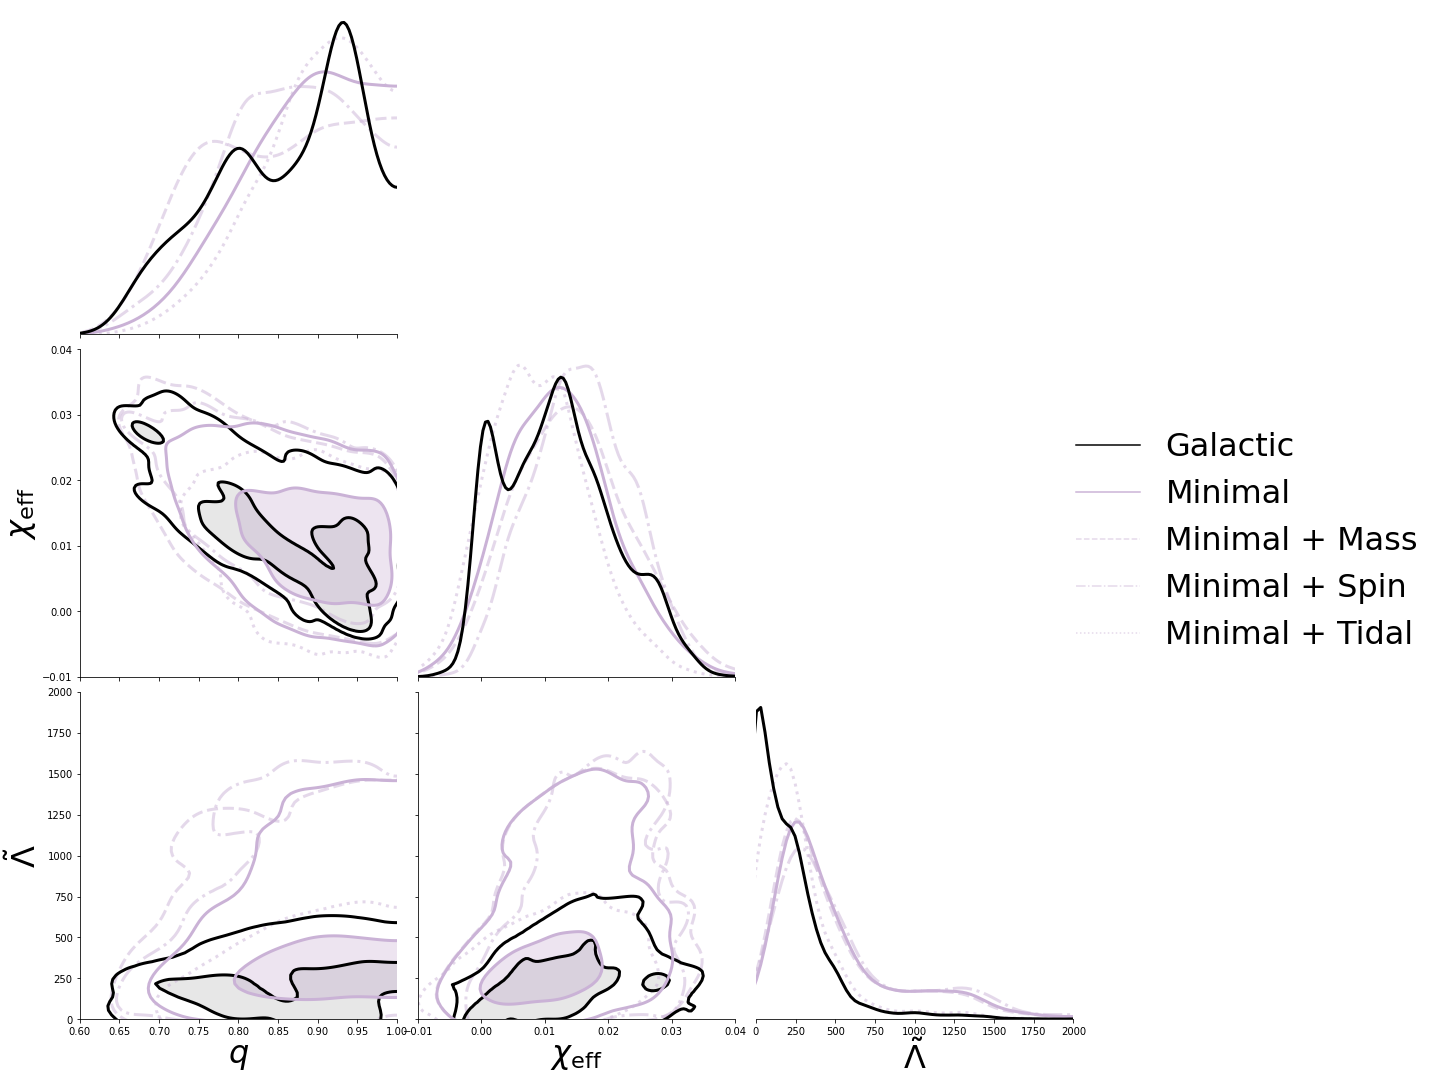

In [16]:
# make a corner plot of the transformed variables

fancy_corner(marg_df,["q","chi_eff",'lambdatilde'],height=5.)